# BÀI TẬP THỰC HÀNH TỔNG HỢP

# Một số kĩ thuật xử lí ảnh nâng cao

1. Censoring face
2. Color segmentation


# Censoring Face

Đoạn mã sau sẽ detect faces trong ảnh đầu vào, 
sau đó sẽ áp dụng kĩ thuật blurring để làm nhoè ảnh - làm cho ảnh không rõ mặt

Censoring face là kĩ thuật thường gặp để giúp bảo vệ tính riêng tư.

1. Để detect face, cần phải có hai bước, nạp model đã có sẵn - file .xml vào biến face_cascade - và sau đó gọi hàm face_cascade.detectMultiScale
2. Sau khi có bounding box (x,y,w,h) - lấy vùng ảnh ra và gọi hàm cv2.GaussianBlur để làm nhoè ảnh
3. Merge trở lại ảnh gốc.
4. Có thể thay thế ảnh khuôn mặt bằng một ảnh khác để dấu khuôn mặt gốc.

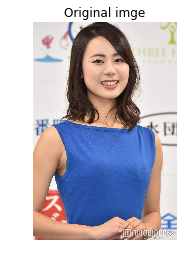

The cascade classifier xml file already existed



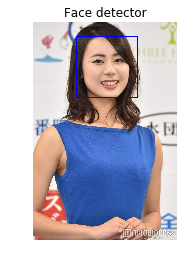

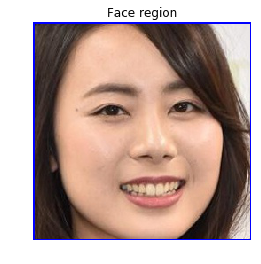

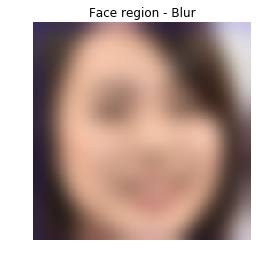

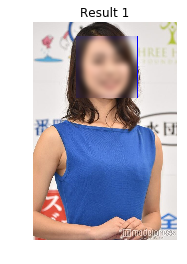

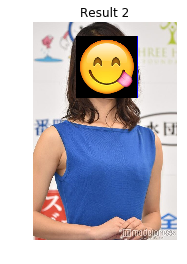

In [46]:
# written by B2DL

import cv2
from skimage import  io
import matplotlib.pyplot as plt
import os.path
import urllib

import sys
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# MAIN 
# load image from url 

#url_img = 'https://ih0.redbubble.net/image.513707611.9778/flat,800x800,075,f.jpg'
url_img = 'https://pbs.twimg.com/profile_images/541920956449435651/iHq9_qcq_400x400.png'
img = io.imread(url_img)
emojiimg = 'emojiface.jpg'
cv2.imwrite(emojiimg, cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) 
eimg = cv2.imread(emojiimg)

#url_img = 'http://media.phunutoday.vn/files/upload_images/2014/12/13/hoa-hau-the-gioi-2007-phunu.jpg'
url_img = 'https://media.ngoisao.vn/resize_580/news/2016/12/10/hoa-hau-nhat-ban-5-ngoisao.vn-w580-h877.jpg'
img = io.imread(url_img)
saveimg = 'censorfacedemo.jpg'
cv2.imwrite(saveimg, cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) 
img = cv2.imread(saveimg)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face_classifier_xml = 'my_haarcascade_frontalface_default.xml'
ret = os.path.exists(face_classifier_xml)

if ret:
    print('The cascade classifier xml file already existed\n')
else:
    print('Downloading the cascade classifier xml file from Internet ...\n')
    face_classifier_url= 'https://raw.githubusercontent.com/shantnu/Webcam-Face-Detect/master/' +     'haarcascade_frontalface_default.xml'
    resp = urlopen(face_classifier_url)
    data = resp.read() 

    #open the file for writing
    fh = open(face_classifier_xml, "wb")

    # read from request while writing to file
    fh.write(data)
    fh.close()
    resp.close()

plt.axis('off')
plt.title('Original imge')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
    
face_cascade = cv2.CascadeClassifier(face_classifier_xml)

#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(gray_img, 1.25, 3)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    plt.axis('off')
    plt.title('Face detector')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    face_img = img[y:y+h, x:x+w]
    
    eimg = cv2.resize(eimg, (w,h), interpolation = cv2.INTER_CUBIC)
    
    plt.axis('off')
    plt.title('Face region')
    plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # apply a gaussian blur on this new recangle image
    blur_img = cv2.GaussianBlur(face_img,(71, 71), 0)
    plt.axis('off')
    plt.title('Face region - Blur')
    plt.imshow(cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # merge to original img
    imz = img.copy()
    imz[y:y+blur_img.shape[0], x:x+blur_img.shape[1]] = blur_img
    plt.axis('off')
    plt.title('Result 1')
    plt.imshow(cv2.cvtColor(imz, cv2.COLOR_BGR2RGB))
    plt.show()

    # replace by emoji
    imw = img.copy()
    imw[y:y+blur_img.shape[0], x:x+blur_img.shape[1]] = eimg
    plt.axis('off')
    plt.title('Result 2')
    plt.imshow(cv2.cvtColor(imw, cv2.COLOR_BGR2RGB))
    plt.show()


# Color Segmentation

Đoạn mã sau sẽ phát hiện các vùng trong ảnh có với một màu sắc đã xác định trước. 
Ví dụ, nếu là biển báo giao thông thì vùng ảnh có thể là màu đỏ hoặc màu xanh.

1. Xác định range tương ứng với mỗi màu. Thường hệ màu HSV được dùng nên cần chuyển ảnh sang hệ màu HSV trước.
2. Gọi hàm cv2.inRange để loại bỏ các điểm ảnh không thuộc range trên. Lúc này kết quả là ảnh nhị phân, trong đó điểm màu trắng là điểm thuộc vùng có màu cần tìm.
3. Gọi hàm cv2.bitwise_and giữa mask và ảnh gốc để minh hoạ cho vùng đã được tách ra (segmentation).

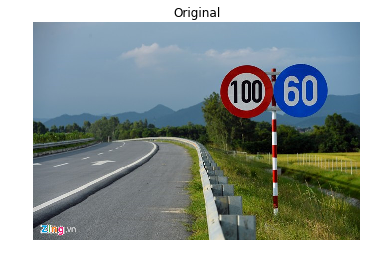

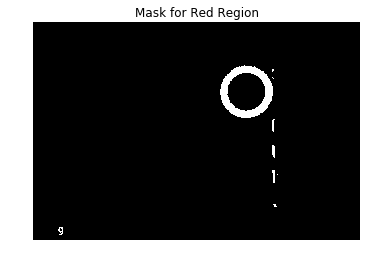

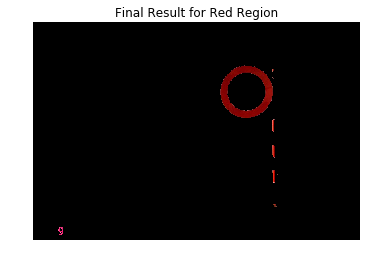

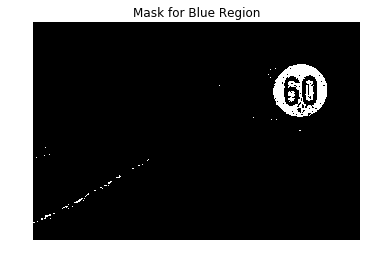

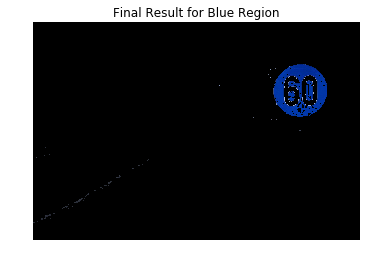

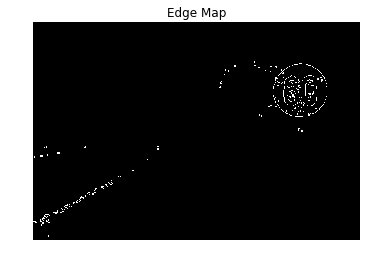

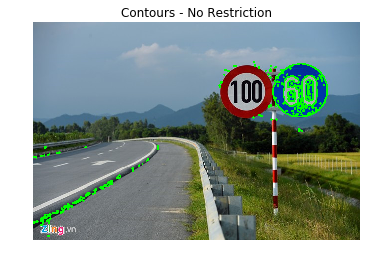

In [94]:
#written by B2DL

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import  io
import random

# read an image from URL
def imreadx(url, img_name):
    img = io.imread(url)
    outimg = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(img_name, outimg) 
    
    return outimg

def imshowx(img, title='B2DL'):
    # Get current size --> change the size
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    
    plt.axis('off') 
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def imshowgrayx(img, title='B2DL'):
    plt.axis('off') 
    plt.title(title)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.show()

url = 'https://znews-photo-td.zadn.vn/w660/Uploaded/rohuouj/2015_12_11/3_zing.jpg'
tds_img = 'tds-5.jpg'

#url = 'http://media.phapluatplus.vn/files/tranlinh/2016/04/04/gt2-0930.jpg'
#tds_img = 'tds-6.jpg'

img = imreadx(url, tds_img)
imshowx(img, 'Original')

# convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# mask of red - dùng để cô lập các pixel có màu đỏ Red trong không gian màu HSV 
mask_r1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
#imshowgrayx(mask_r1, 'Mask Range 1')

mask_r2 = cv2.inRange(hsv, (160, 100, 100), (180, 255, 255))
#imshowgrayx(mask_r2, 'Mask Range 1')

# điều kiện HOẶC
mask_r = cv2.bitwise_or(mask_r1, mask_r2)
imshowgrayx(mask_r, 'Mask for Red Region')

# hiển thị kết quả trên ảnh gốc
target = cv2.bitwise_and(img, img, mask=mask_r)
imshowx(target, 'Final Result for Red Region')

# mask of blue - dùng để cô lập các pixel có màu đỏ Red trong không gian màu HSV 
mask_b = cv2.inRange(hsv, (110, 50, 50), (130, 255, 255))
imshowgrayx(mask_b, 'Mask for Blue Region')

# hiển thị kết quả trên ảnh gốc
target = cv2.bitwise_and(img, img, mask=mask_b)
imshowx(target, 'Final Result for Blue Region')

edge_img = cv2.Canny(mask_b, 30, 150)
imshowgrayx(edge_img, 'Edge Map')

itmp, cnts, hierarchy = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img2 = img.copy()
cv2.drawContours(img2, cnts, -1, (0, 255, 0), 2)
imshowx(img2, 'Contours - No Restriction')


# Edge - Contour Detection

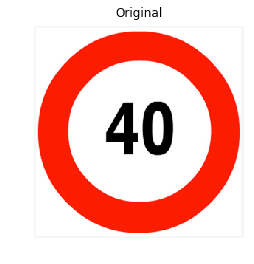

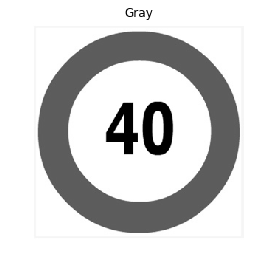

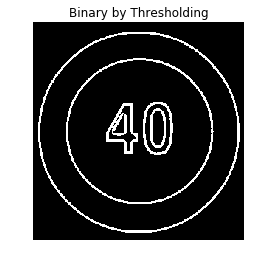

Num contours 14


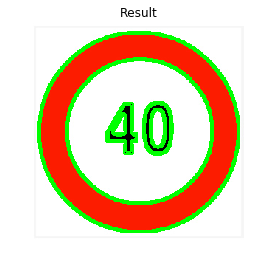

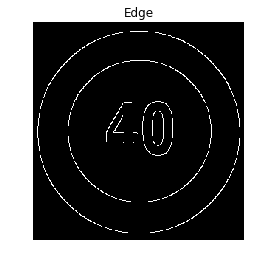

Num contours 1


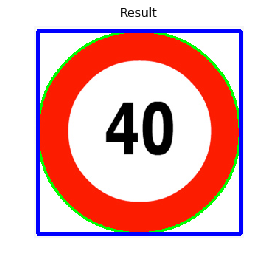

In [89]:
#written by B2DL

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import  io
import random

# read an image from URL
def imreadx(url, img_name):
    img = io.imread(url)
    outimg = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(img_name, outimg) 
    
    return outimg

def imshowx(img, title='B2DL'):
    # Get current size --> change the size
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    
    plt.axis('off') 
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def imshowgrayx(img, title='B2DL'):
    plt.axis('off') 
    plt.title(title)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.show()

url = 'http://www.baoholaodong247.com/Portals/26918/127.jpg'
tds_img = 'tds-6.jpg'

img = imreadx(url, tds_img)
imshowx(img, 'Original')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshowgrayx(gray, 'Gray')

adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10)
imshowgrayx(adaptive_thresh, 'Binary by Thresholding')

itmp, cnts, hierarchy = cv2.findContours(adaptive_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img2 = img.copy();
print('Num contours {}'.format(len(cnts)))
cv2.drawContours(img2, cnts, -1, (0, 255, 0), 2)
imshowx(img2, 'Result')


edge_img = cv2.Canny(gray, 50, 150)
imshowgrayx(edge_img, 'Edge')
itmp, cnts, hierarchy = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img2 = img.copy();
print('Num contours {}'.format(len(cnts)))
cv2.drawContours(img2, cnts, -1, (0, 255, 0), 2)
# find bounding box
x,y,w,h = cv2.boundingRect(cnts[0])
cv2.rectangle(img2,(x,y),(x+w,y+h),(255,0,0), 3)
imshowx(img2, 'Result')


